In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [7]:
### Function to convert dataframe to timeseries object
def create_ts_object(df):
    df.Timestamp = pd.to_datetime(df.Timestamp)
    df.set_index("Timestamp", inplace=True)
    df = df.asfreq('H')

    return df.head()

### Import Digester 19 data

In [8]:
data19 = pd.read_csv("~/Documents/Data/FinalDatasetForModel/Digester19data.csv")
data19.drop(['Dig_19_woodload', 'Dig_19_Liq_circ',
       'Digester_19_temperature', 'Digester_19_pressure',
       'Dig_19_phase_Comm Fail', 'Dig_19_phase_Configure',
       'Dig_19_phase_HP GAS RELEASE', 'Dig_19_phase_LIQUOR LOADING',
       'Dig_19_phase_LP GAS RELEASE', 'Dig_19_phase_PULP DISCHARGE',
       'Dig_19_phase_READY FOR LIQUOR',
       'Dig_19_phase_READY FOR PULP DISCH',
       'Dig_19_phase_READY FOR STEAMING', 'Dig_19_phase_READY FOR WOOD',
       'Dig_19_phase_SFACTOR TGT REACHED',
       'Dig_19_phase_SMOOTH STEAM FIXED',
       'Dig_19_phase_SMOOTH STEAM RAMP', 'Dig_19_phase_Scan Timeout',
       'Dig_19_phase_TEMP RAMP TO 110C', 'Dig_19_phase_TEMP RAMP TO 126C',
       'Dig_19_phase_TEMP RAMP TO TMAX', 'Dig_19_phase_VALVE CHECK',
       'Dig_19_phase_WOODLOAD COMPLETE', 'Dig_19_phase_WOODLOADING', 'Dig_19_phase_PULP DISCH COMPLETE'], axis = 1, inplace=True)

create_ts_object(data19)

,Dig_19_HX
Timestamp,
2020-11-01 00:00:00,0.844747
2020-11-01 01:00:00,0.008280
2020-11-01 02:00:00,0.031892
2020-11-01 03:00:00,0.000000
2020-11-01 04:00:00,0.000000


### Stationarity

In [9]:
sts.adfuller(data19.Dig_19_HX)

(-4.29198388888337,
 0.00045862703312776043,
 27,
 2181,
 {'1%': -3.4333518400589074,
  '5%': -2.8628661117509484,
  '10%': -2.567475955039574},
 10981.35292596673)

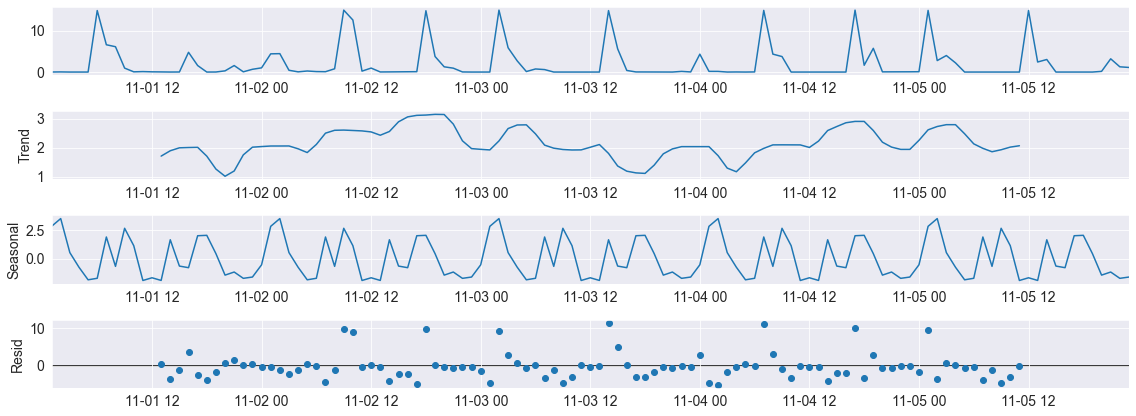

In [10]:
seas_dec = seasonal_decompose(data19[1:120], model = "additive")
seas_dec.plot()
plt.show()

### ACF

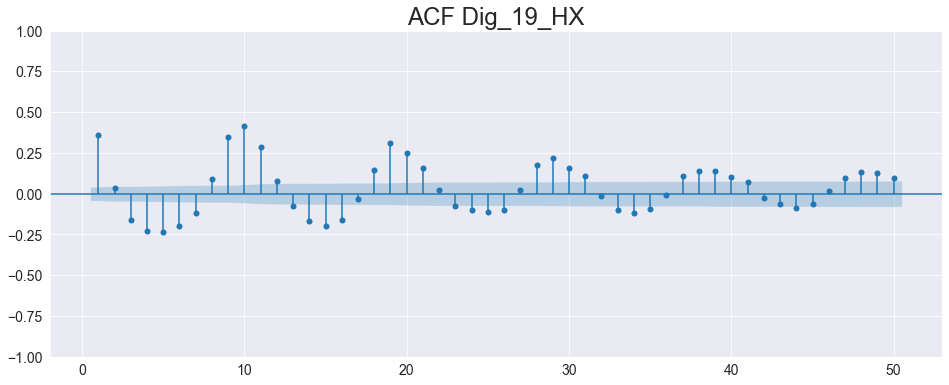

In [11]:
sgt.plot_acf(data19.Dig_19_HX, lags = 50, zero = False)
plt.title("ACF Dig_19_HX", size = 24)
plt.show()

### PACF

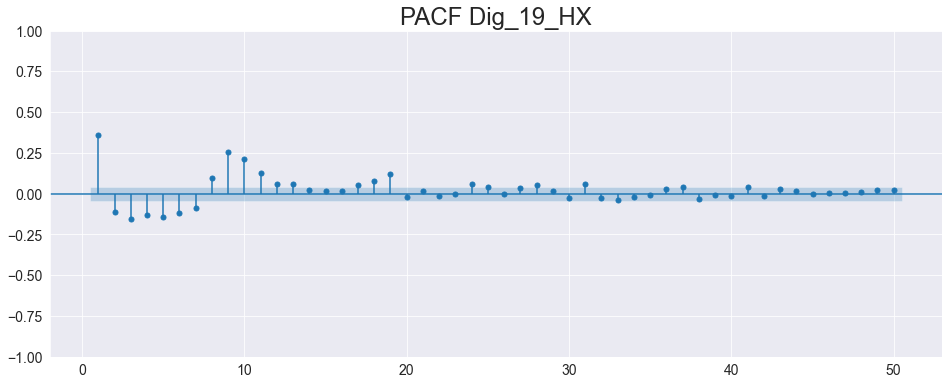

In [12]:
sgt.plot_pacf(data19.Dig_19_HX, lags = 50, zero = False, method = ('ols'))
plt.title("PACF Dig_19_HX", size = 24)
plt.show()

In [13]:
#  Spare copy
data19_twin1 = data19.copy()

### Normalization

In [14]:
# define functions to scale and reverse-scale data, looping through the columns, and passing a scaler type
def scale_data(data, scaler):
    for col in data.columns.values:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data.head()

In [15]:
scaler = MinMaxScaler()
data19_twin = data19.copy()
scale_data(data19_twin, scaler)

,Dig_19_HX
Timestamp,
2020-11-01 00:00:00,0.056316
2020-11-01 01:00:00,0.000552
2020-11-01 02:00:00,0.002126
2020-11-01 03:00:00,0.000000
2020-11-01 04:00:00,0.000000


### Data Split

In [16]:
train_size = int(len(data19_twin)*0.85)
val_size = train_size + int(len(data19_twin)*0.10)
train_data19 = data19_twin.iloc[:train_size]
val_data19 = data19_twin.iloc[train_size:val_size]
test_data19 = data19_twin.iloc[val_size:]

In [17]:
val_data19.head()

,Dig_19_HX
Timestamp,
2021-01-18 05:00:00,0.124957
2021-01-18 06:00:00,0.122927
2021-01-18 07:00:00,0.603308
2021-01-18 08:00:00,0.711812
2021-01-18 09:00:00,0.348484


### Auto ARIMA Model

In [18]:
model_auto = auto_arima(train_data19.Dig_19_HX, max_order = None, max_p = 30, max_q = 40, maxiter = 100, alpha = 0.05, n_jobs = -1, trend = 'ct',)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\USER\AppData\Local\Programs\Python\Pyt

In [19]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 -13.708
Date:                Sat, 12 Mar 2022   AIC                             39.416
Time:                        12:49:16   BIC                             72.638
Sample:                             0   HQIC                            51.654
                               - 1877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0009      0.003     -0.347      0.729      -0.006       0.004
drift       5.105e-07   1.57e-06      0.325      0.745   -2.57e-06    3.59e-06
ar.L1          0.4580      0.159      2.878      0.004       0.146       0.770
ma.L1         -0.8674      0.165     -5.254      0.000      -1.191      -0.544
ma.L2         -0.0024      0.089     -0.027      0.978      -0.178       0.173
sigma2         0.0646      0.003     20.903      0.000       0.059       0.071
===================================================================================
Ljung-Box (L1) (Q):                  22.33   Jarque-Bera (JB):              3726.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             2.21
Prob(H) (two-sided):                  0.23   Kurtosis:                         8.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA Model Residual Analysis

In [20]:
data19_resid_dataset = train_data19.copy()
data19_resid_dataset['residuals'] = model_auto.resid()

In [21]:
print(data19_resid_dataset.residuals.mean())
print(data19_resid_dataset.residuals.var())

0.0032948070229021067
0.059177931301213


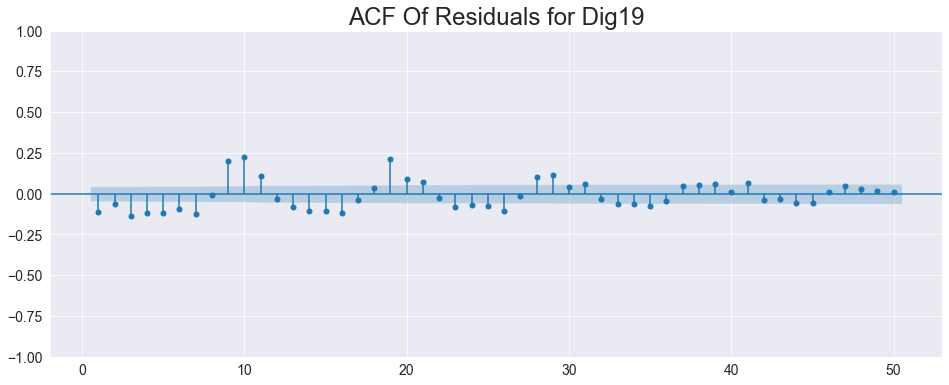

In [22]:
sgt.plot_acf(data19_resid_dataset.residuals, zero = False, lags = 50)
plt.title("ACF Of Residuals for Dig19",size=24)
plt.show()

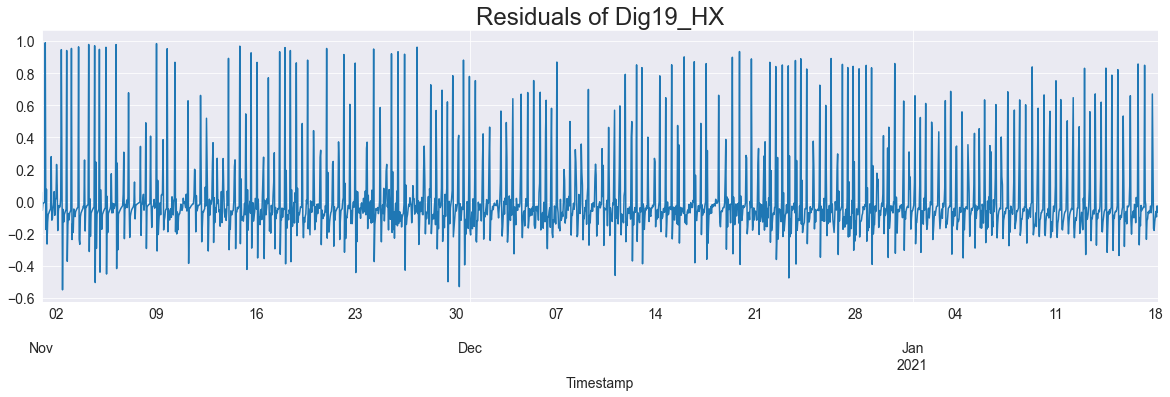

In [23]:
data19_resid_dataset.residuals.plot(figsize=(20,5))
plt.title("Residuals of Dig19_HX",size=24)
plt.show()

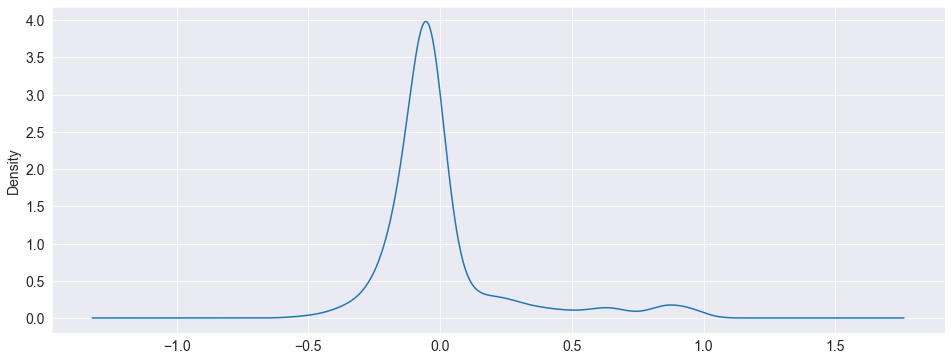

In [24]:
data19_resid_dataset.residuals.plot(kind='kde')
plt.show()

### Model Validation

In [25]:
start_date = "2021-01-18 05:00:00"
end_date = "2021-01-27 08:00:00"

In [26]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(val_data19), index = val_data19.index))

In [27]:
scaler2 = MinMaxScaler()
scaler2.fit_transform(data19_twin1.Dig_19_HX.values.reshape(-1, 1))

array([[0.05631648],
       [0.00055197],
       [0.00212614],
       ...,
       [0.00153982],
       [0.00034392],
       [0.00197571]])

In [28]:
# Invert the scale of predictions
df_pred2 = scaler2.inverse_transform(df_pred.values.reshape(-1, 1))

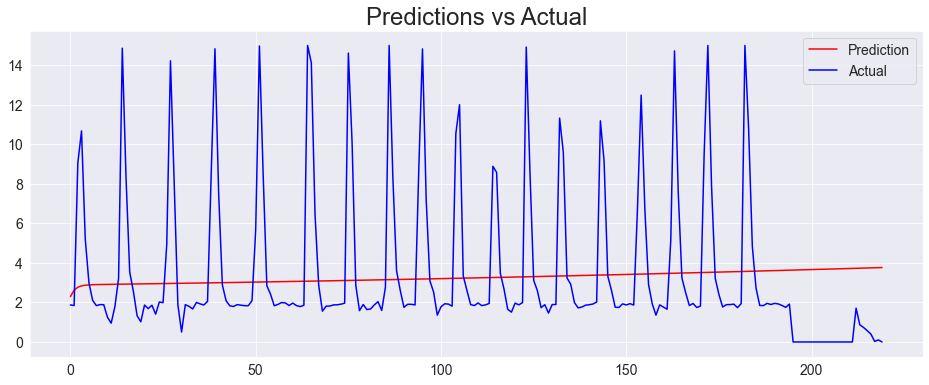

In [29]:
plt.plot(df_pred.index.to_numpy(), df_pred2, color = "red")
plt.plot(df_pred.index, data19_twin1.Dig_19_HX[start_date:end_date].to_numpy(), color = "blue")
plt.legend(['Prediction', 'Actual'])
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Performance Metrics

In [30]:
ndapred, ndaactual = df_pred, val_data19.Dig_19_HX.to_numpy()

In [31]:
print(ndapred.shape)
print(ndaactual.shape)

(220, 1)
(220,)


In [32]:
print("MAE: %.4f" %mean_absolute_error(ndaactual, ndapred))
print("RMSE: %.4f" %np.sqrt(mean_squared_error(ndaactual, ndapred)))

MAE: 0.1789
RMSE: 0.2601


In [33]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig19pred.npy", df_pred2)

### Forecast

In [34]:
fcast = pd.DataFrame(model_auto.predict(n_periods = len(test_data19), index = test_data19.index))

In [38]:
fcast = scaler2.inverse_transform(fcast.values.reshape(-1, 1))

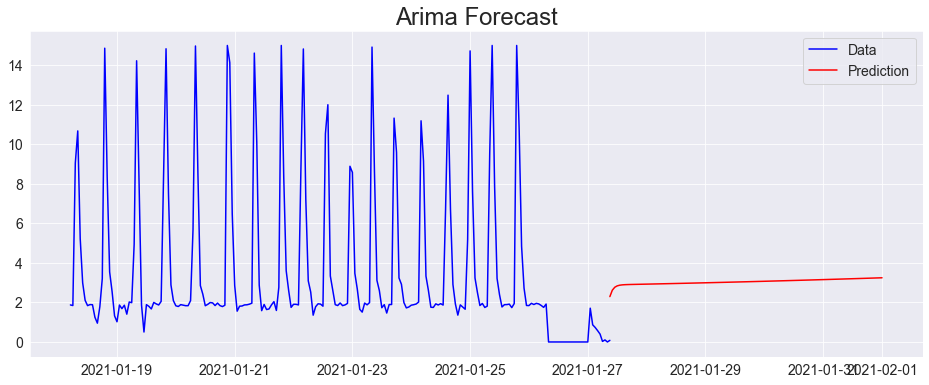

In [39]:
plt.plot(data19_twin1.index[1877:2098], data19_twin1.Dig_19_HX[1877:2098].to_numpy(), color = "blue")
plt.plot(test_data19.index, fcast, color = "red")
plt.legend(['Data', 'Prediction'])
plt.title("Arima Forecast", size = 24)
plt.show()

In [37]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig19fcast.npy", fcast)